<a href="https://colab.research.google.com/github/rajeevfromkrec/pytorch/blob/master/Logistic_regression_practice_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [2]:
dataset = MNIST(root='data/', download=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [3]:
!ls

data  sample_data


In [8]:
import os
os.listdir('./data/')

['MNIST']

In [10]:
len(dataset)

60000

In [11]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

In [12]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FF885DF4F60>, 5)

In [13]:
import cv2

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline


In [17]:
image,label=dataset[0]

5


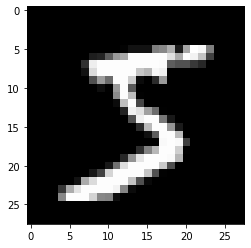

In [20]:
plt.imshow(image, cmap='gray')
print(label)

In [21]:
import torchvision.transforms as transforms

In [23]:
dataset=MNIST(root='data/', train=True, transform=transforms.ToTensor())

In [27]:
image_tensor,label= dataset[0]

image_tensor.shape

torch.Size([1, 28, 28])

In [30]:
from torch.utils.data import random_split

In [33]:
train_ds,val_ds= random_split(dataset,[50000,10000])

In [34]:
from torch.utils.data import DataLoader

In [39]:
batch_size=128

In [40]:
train_dl=DataLoader(train_ds,batch_size,shuffle=True)

In [41]:
val_dl=DataLoader(val_ds,batch_size)

In [42]:
import torch.nn as nn

In [43]:
input_size= 28*28
num_classes=10

In [44]:
model=nn.Linear(input_size, num_classes)

In [50]:
model.weight.shape

torch.Size([10, 784])

In [52]:
for images,labels in train_dl:
  output=model(images.reshape(-1,784))

In [53]:
output[0]

tensor([ 0.0423, -0.2331, -0.2797,  0.1364, -0.0564,  0.0549,  0.0276,  0.1456,
        -0.0092, -0.0531], grad_fn=<SelectBackward>)

In [64]:
class MnistModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear=nn.Linear(input_size,num_classes)

  def forward(self,xb):
    xb=xb.reshape(-1,784)
    out=self.linear(xb)
    return out




In [65]:
model=MnistModel()

In [66]:
model.linear.weight.shape

torch.Size([10, 784])

In [67]:
list( model.parameters())

[Parameter containing:
 tensor([[-0.0349, -0.0329, -0.0196,  ...,  0.0096, -0.0242,  0.0113],
         [ 0.0235,  0.0184,  0.0114,  ...,  0.0028,  0.0025,  0.0185],
         [ 0.0356, -0.0244, -0.0190,  ..., -0.0247, -0.0341, -0.0092],
         ...,
         [-0.0332, -0.0284,  0.0031,  ..., -0.0097,  0.0337, -0.0220],
         [ 0.0011,  0.0280, -0.0043,  ...,  0.0038,  0.0093,  0.0145],
         [-0.0351, -0.0297, -0.0336,  ...,  0.0164, -0.0103,  0.0214]],
        requires_grad=True), Parameter containing:
 tensor([-0.0187, -0.0009, -0.0190,  0.0315, -0.0332, -0.0101, -0.0214,  0.0032,
          0.0203,  0.0247], requires_grad=True)]

In [68]:
for images,labels in train_dl:
  print(images.shape)
  output=model(images)
  break

torch.Size([128, 1, 28, 28])


In [70]:
output.shape

torch.Size([128, 10])

In [71]:
import torch.nn.functional as F

In [73]:
probs=F.softmax(output, dim=1)

In [75]:
probs[0,:]

tensor([0.0958, 0.0963, 0.0571, 0.1161, 0.1100, 0.1176, 0.1153, 0.0919, 0.1220,
        0.0779], grad_fn=<SliceBackward>)

In [77]:
max_prob,preds= torch.max(output,dim=1)

In [93]:
def accuracy(output, labels):
  _,preds=torch.max(output,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [79]:
loss_fn=F.cross_entropy

In [80]:
loss=loss_fn(output,labels)

In [81]:
loss

tensor(2.3207, grad_fn=<NllLossBackward>)

In [97]:
class MnistModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear=nn.Linear(input_size,num_classes)

  def forward(self,xb):
    xb=xb.reshape(-1,784)
    out=self.linear(xb)
    return out

  def training_step(self,batch):
    images,labels=batch
    out=self(images)
    loss=F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images,labels=batch
    out=self(images)
    loss=F.cross_entropy(out,labels)
    acc=accuracy(out,labels)
    return {'val_loss':loss,'val_acc':acc}

  def validation_epoch_end(self,outputs):
    batch_losses=[x['val_loss'] for x in outputs]
    epoch_loss =torch.stack(batch_losses).mean()
    batch_acc = [x['val_acc'] for x in outputs]
    epoch_acc= torch.stack(batch_acc).mean()
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [98]:
model=MnistModel()

In [99]:
def evaluate(model,val_dl):
  outputs=[model.validation_step(batch) for batch in val_dl]
  return model.validation_epoch_end(outputs)

In [100]:
def fit(epochs,lr,model,train_dl,val_dl,opt_fn=torch.optim.SGD):
  history=[]
  optimizer=opt_fn(model.parameters(),lr)
  for epoch in range(epochs):
    for batch in train_dl:
      loss=model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    result=evaluate(model,val_dl)
    model.epoch_end(epoch,result)
    history.append(result)
  return history


In [101]:
result0= evaluate(model,val_dl)

In [102]:
result0

{'val_acc': 0.08356408029794693, 'val_loss': 2.3251147270202637}

In [104]:
history1 = fit(5, 0.001, model, train_dl, val_dl)

Epoch [0], val_loss: 1.9571, val_acc: 0.6233
Epoch [1], val_loss: 1.6871, val_acc: 0.7184
Epoch [2], val_loss: 1.4855, val_acc: 0.7530
Epoch [3], val_loss: 1.3329, val_acc: 0.7752
Epoch [4], val_loss: 1.2155, val_acc: 0.7907


In [106]:
history2 = fit(5, 0.001, model, train_dl, val_dl)

Epoch [0], val_loss: 1.1231, val_acc: 0.8015
Epoch [1], val_loss: 1.0489, val_acc: 0.8085
Epoch [2], val_loss: 0.9881, val_acc: 0.8155
Epoch [3], val_loss: 0.9375, val_acc: 0.8214
Epoch [4], val_loss: 0.8946, val_acc: 0.8260


In [107]:
history3 = fit(20, 0.001, model, train_dl, val_dl)

Epoch [0], val_loss: 0.8580, val_acc: 0.8303
Epoch [1], val_loss: 0.8262, val_acc: 0.8340
Epoch [2], val_loss: 0.7983, val_acc: 0.8377
Epoch [3], val_loss: 0.7737, val_acc: 0.8396
Epoch [4], val_loss: 0.7519, val_acc: 0.8429
Epoch [5], val_loss: 0.7322, val_acc: 0.8451
Epoch [6], val_loss: 0.7145, val_acc: 0.8479
Epoch [7], val_loss: 0.6984, val_acc: 0.8491
Epoch [8], val_loss: 0.6837, val_acc: 0.8501
Epoch [9], val_loss: 0.6703, val_acc: 0.8513
Epoch [10], val_loss: 0.6579, val_acc: 0.8525
Epoch [11], val_loss: 0.6465, val_acc: 0.8537
Epoch [12], val_loss: 0.6359, val_acc: 0.8550
Epoch [13], val_loss: 0.6261, val_acc: 0.8564
Epoch [14], val_loss: 0.6169, val_acc: 0.8567
Epoch [15], val_loss: 0.6084, val_acc: 0.8576
Epoch [16], val_loss: 0.6003, val_acc: 0.8586
Epoch [17], val_loss: 0.5928, val_acc: 0.8596
Epoch [18], val_loss: 0.5856, val_acc: 0.8602
Epoch [19], val_loss: 0.5789, val_acc: 0.8609


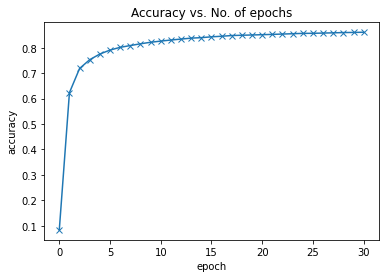

In [108]:
history = [result0] + history1 + history2 + history3 
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');